# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predtictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.


## Imports

The following code cells import all the libraries necessary to run this notebook. As there are a lot of imports, they are divided into four cells according to their function for easier management. 

In [1]:
# General utilities

# file management
import os
# downloading datasets
import requests
# url construction
from urllib.parse import urljoin

In [2]:
# Plotting libraries

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Data manipulation
import pandas as pd
import numpy as np

In [4]:
# scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis 
from sklearn.base import TransformerMixin
from sklearn.cluster import FeatureAgglomeration
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from category_encoders import TargetEncoder

## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by [Cortez et al.][cortezetal] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines (SVM), multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [RPaper,RDatasheet].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts [RDatasheet].

The data information sheet distributed with the data [R] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.

### Procedure

1. [Acquire the data](#Acquire-the-dataset)
1. [Split the data](#Split-the-data)
1. [Explore the data](#Explore-the-dataset)
    1. [View a sample of each dataset](#View-the-data)
    1. [View the distribution of each feature](#View-the-distribution-of-each-feature)
    1. [View distribution of target variable](#View-distribution-of-target-variable)
    1. [View correlations between features](#View-feature-correlations)
    1. [Assess relative influence of each feature on the target variable](#Assess-relative-influence-of-each-feature-on-the-target-variable)
1. [Feature scaling](#Feature-scaling)
1. [Dimensionality reduction](#Dimensionality-reduction)
    1. [Feature selection](#Feature-selection)
    1. [Principal Components Analysis](#Principal-components-analysis) 
1. Model selection
    1. Decide on whether the problem will be cast as binary classification, multiclass classification, or regression
    1. Adjust target variable as necessary
    1. Select some suitable models
1. Hyperparameter tuning
    1. Construct a grid search or randomized search to test various combinations of hyperparameters
1. Fit and assess models
    1. Fit each model/hyperparameter/featureset combination
    1. Conduct assessment appropriate to each combination
    1. Select best candidates and fine tune
1. Test predictions
    1. Use trained model(s) to predict test set
    2. Assess model performance on test set


### Acquire the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc. 

In [5]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

The data is then loaded into two pandas dataframes, one for the red wine dataset and one for the white.

In [6]:
# Load red wine and white wine datasets into pandas DataFrames
redwine = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
whitewine = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Split the data
Each of the two wine datasets is split into a training set, representing 80% of the data, and a test set, representing the other 20%. The data is shuffled before splitting and the split is stratified on the `quality` output variable. This ensures that each category is proportionally represented in both the training and test sets. It is necessary to do this because, as noted [below](#View-distribution-of-target-variable), the target variable is unevenly distributed. The input features are also split from the target variable in both the training and testing sets. The input feature DataFrame names are prefixed with an `X` and the targets with a `y`. The split is conducted using `sklearn.model_selection.train_test_split()` [5].

In [7]:
# Merge quality ratngs so that 3,4 = 0 (low), 5,6 = 1 (medium), 7,8,9 = 2 (high)
for w in redwine, whitewine:
    w['quality_cat'] = np.where(w['quality'] <= 4, 0, np.where(w['quality'] >= 7, 2, 1))

In [8]:
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_rw, X_test_rw, y_train_rw, y_test_rw = \
    train_test_split(redwine.drop('quality', axis=1), redwine['quality'], stratify=redwine['quality'], test_size=0.2)
# Split red wine data into random training and test (20%) subsets with stratified sampling on quality
X_train_ww, X_test_ww, y_train_ww, y_test_ww = \
    train_test_split(whitewine.drop('quality', axis=1), whitewine['quality'], stratify=whitewine['quality'], test_size=0.2)

In [9]:
X_train_rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_cat
1044,6.4,0.390,0.33,3.3,0.046,12.0,53.0,0.99294,3.36,0.62,12.2,1
428,9.1,0.520,0.33,1.3,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,1
1406,8.2,0.240,0.34,5.1,0.062,8.0,22.0,0.99740,3.22,0.94,10.9,1
1293,7.5,0.755,0.00,1.9,0.084,6.0,12.0,0.99672,3.34,0.49,9.7,0
424,7.7,0.960,0.20,2.0,0.047,15.0,60.0,0.99550,3.36,0.44,10.9,1


In [10]:
# Create new train and test y values from the quality_cat column 
# and remove the column from the X value datasets
# Red wine
y_train_cat_rw, y_test_cat_rw = X_train_rw['quality_cat'], X_test_rw['quality_cat']
X_train_rw, X_test_rw = X_train_rw.drop('quality_cat', axis=1), X_test_rw.drop('quality_cat', axis=1)

# White wine
y_train_cat_ww, y_test_cat_ww = X_train_ww['quality_cat'], X_test_ww['quality_cat']
X_train_ww, X_test_ww = X_train_ww.drop('quality_cat', axis=1), X_test_ww.drop('quality_cat', axis=1)

## Explore the dataset
Two DataFrames are created, `rw` and `ww`, representing The red wine and white wine datasets respectively. They are subset from the original full datasets as loaded from csv using the training set indices. They will be used to explore the data. The instances in the test subsets must remain unseen if the analysis is to remain unbiased by their contents.

In [11]:
rw = redwine.iloc[X_train_rw.index]
ww = whitewine.iloc[X_train_ww.index]
# Give the DataFrames name attributes for quick labelling of output
rw.name, ww.name = "Red Wine", "White Wine"

### View the data
The first five rows of each of the two DataFrames are viewed using `pandas.DataFrame.head()`. This gives a general idea of the structure of the dataset.

In [12]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.head())

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
1044,6.4,0.390,0.33,3.3,0.046,12.0,53.0,0.99294,3.36,0.62,12.2,6,1
428,9.1,0.520,0.33,1.3,0.070,9.0,30.0,0.99780,3.24,0.60,9.3,5,1
1406,8.2,0.240,0.34,5.1,0.062,8.0,22.0,0.99740,3.22,0.94,10.9,6,1
1293,7.5,0.755,0.00,1.9,0.084,6.0,12.0,0.99672,3.34,0.49,9.7,4,0
424,7.7,0.960,0.20,2.0,0.047,15.0,60.0,0.99550,3.36,0.44,10.9,5,1


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
4646,5.9,0.180,0.28,1.0,0.037,24.0,88.0,0.99094,3.29,0.55,10.65,7,2
4771,6.8,0.270,0.30,13.0,0.047,69.0,160.0,0.99705,3.16,0.50,9.60,6,1
377,7.3,0.200,0.44,1.4,0.045,21.0,98.0,0.99240,3.15,0.46,10.00,7,2
4831,5.8,0.380,0.26,1.1,0.058,20.0,140.0,0.99271,3.27,0.43,9.70,6,1
2559,5.7,0.255,0.65,1.2,0.079,17.0,137.0,0.99307,3.20,0.42,9.40,5,1


***

The `DataFrame.info()` function returns the name, count, and datatype of each feature in the DataFrame. Each of the two wine datasets consists of 11 input variables of type `float64` and one out put variable of type `int64`. The red wine data contains 1599 samples and the white wine data contains 4898. Neither has any missing values.

In [13]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    print(w.info())

-----------
Red Wine
-----------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1279 entries, 1044 to 561
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1279 non-null   float64
 1   volatile acidity      1279 non-null   float64
 2   citric acid           1279 non-null   float64
 3   residual sugar        1279 non-null   float64
 4   chlorides             1279 non-null   float64
 5   free sulfur dioxide   1279 non-null   float64
 6   total sulfur dioxide  1279 non-null   float64
 7   density               1279 non-null   float64
 8   pH                    1279 non-null   float64
 9   sulphates             1279 non-null   float64
 10  alcohol               1279 non-null   float64
 11  quality               1279 non-null   int64  
 12  quality_cat           1279 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 139.9 KB
None
-----------
White Wine
-----------


***

The `DataFrame.describe()` function returns a table containing descriptive statistics for each of the features.

In [14]:
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    display(w.describe().round(2))

-----------
Red Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
count,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00,1279.0,1279.00,1279.00,1279.00,1279.00,1279.00,1279.00
mean,8.29,0.53,0.27,2.51,0.09,15.88,46.3,1.00,3.31,0.66,10.43,5.64,1.10
std,1.75,0.18,0.19,1.30,0.04,10.31,32.3,0.00,0.15,0.17,1.07,0.81,0.41
min,4.60,0.12,0.00,0.90,0.01,1.00,6.0,0.99,2.74,0.33,8.40,3.00,0.00
25%,7.10,0.39,0.09,1.90,0.07,7.00,22.0,1.00,3.21,0.55,9.50,5.00,1.00
50%,7.90,0.52,0.25,2.20,0.08,14.00,38.0,1.00,3.31,0.62,10.10,6.00,1.00
75%,9.20,0.64,0.42,2.60,0.09,21.00,62.0,1.00,3.40,0.73,11.10,6.00,1.00
max,15.90,1.58,1.00,15.50,0.61,68.00,289.0,1.00,4.01,2.00,14.90,8.00,2.00


-----------
White Wine
-----------


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_cat
count,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00,3918.00
mean,6.85,0.28,0.33,6.39,0.05,35.32,138.33,0.99,3.19,0.49,10.51,5.88,1.18
std,0.84,0.10,0.12,5.09,0.02,17.01,42.55,0.00,0.15,0.11,1.23,0.89,0.47
min,4.20,0.08,0.00,0.60,0.01,3.00,9.00,0.99,2.74,0.23,8.40,3.00,0.00
25%,6.30,0.21,0.26,1.70,0.04,23.12,108.00,0.99,3.09,0.41,9.50,5.00,1.00
50%,6.80,0.26,0.32,5.20,0.04,34.00,134.00,0.99,3.18,0.48,10.40,6.00,1.00
75%,7.30,0.32,0.38,9.80,0.05,46.00,167.00,1.00,3.28,0.55,11.40,6.00,1.00
max,14.20,1.10,1.66,65.80,0.35,289.00,440.00,1.04,3.82,1.08,14.00,9.00,2.00


***

### View the distribution of each feature

`DataFrame.hist()` produces a histogram for each feature which can be displayed with `plt.show()`. Some points to note are:
- It looks like `citric acid` in the red wine dataset, and `residual sugar` in the white wine dataset contain a lot of zero values.
- A number of features have very long tails, in particular `residual sugar`, `chlorides`, `total sulfur dioxide`, and `sulphates`.
- There is considerable variation in the attributes' scales.
- The target values are very unevenly distributed with a great many more instances falling around the medium quality ratings than the low and high ratings.

[4] 50-51

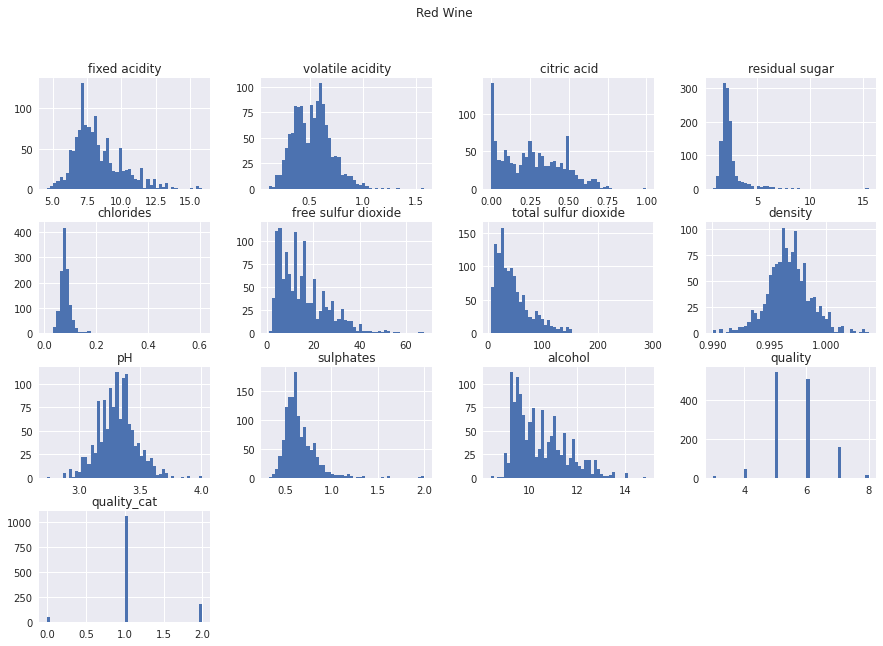

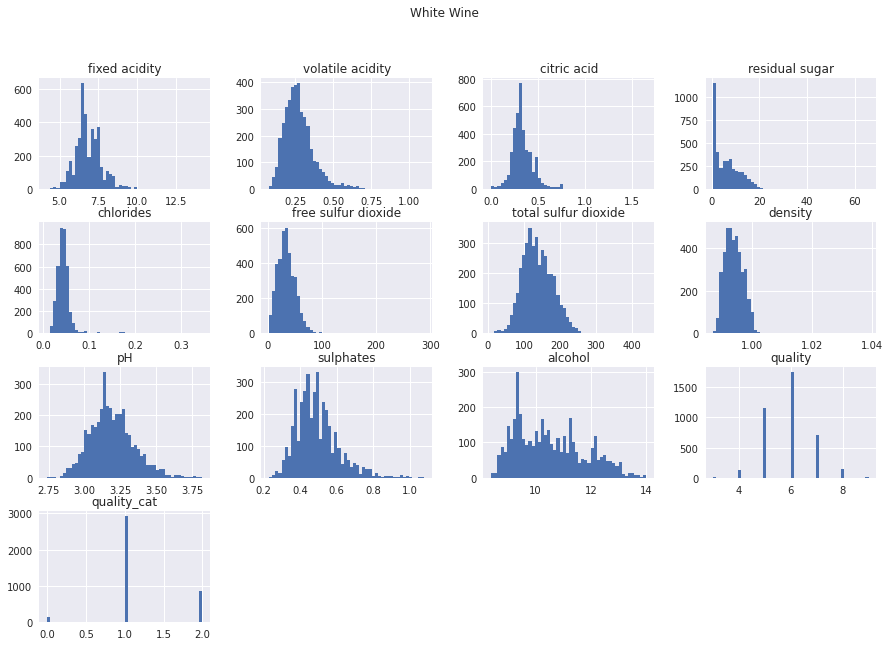

In [15]:
# View a histogram of each feature
for w in rw, ww:
    # Set plot style
    with plt.style.context('seaborn'):
        # Construct histogram with 50 bins for each feature
        hist = w.hist(bins=50, figsize=(15, 10))
        # Title for each set of histograms
        plt.gcf().suptitle(w.name)
    plt.show()

***

### View distribution of target variable
The target variable in this dataset is `quality`. As is obvious from the histograms above, the distribution of the output variable heavily favours the central categories. The red wine dataset is sorted into six ordinal categories from 3 to 8. Categories `5` and `6` represent over 80% of the data. The lowest category, `3`, occurs in only 8 instances, representing 0.6% of the dataset; `4` occurs 42 times  - 1.1% of total ratings. At the upper end of the scale `7` occurs 159 times or ~12% and just 15 red wines, ~1%, hold the higest rating of `8`. 

The white wine dataset shows a similar imbalance. Of its 7 rating categories, 3 to 8, over 90 % fall into the medium group, `5`, `6`, and `7`. Categories `3` and `4` account for a combined 4% of instances, with just 16 wines with a rating of `3`. Similarly, `8` and `9` occur in less than 4% of samples; `9` only occurring 4 times.



In [16]:
# Count occurences of each quality class and calculate percents of total
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # Count occurrences of each category
    wc = w.quality.value_counts()
    # Calculate percent of total number of samples
    wp = round(w.quality.value_counts() / len(w) * 100, 2)
    # Place in dataframe for ease of presentation and display
    df = pd.concat((wc,wp), axis=1)
    df.columns = ('Count', 'Percent')
    print(df)

-----------
Red Wine
-----------
   Count  Percent
5    545    42.61
6    510    39.87
7    159    12.43
4     42     3.28
8     15     1.17
3      8     0.63
-----------
White Wine
-----------
   Count  Percent
6   1758    44.87
5   1166    29.76
7    704    17.97
8    140     3.57
4    130     3.32
3     16     0.41
9      4     0.10


***

### View feature correlations

For each of the wine datasets (red and white), a correlation matrix is calculated using *pandas* `DataFrame.corr()` function. The correlation coefficient is calcualted between each pair of numeric variables using Pearson's r. The resulting matrices are displayed as heatmaps using `seaborn.heatmap()`. The colourmap used is set to saturate at a correlation coefficient of 0.5 so that high correlations are very obvious. For the same reason the diagonal of the correlation matrix, which always holds a 1.0 as it is the value of a feature's correlation with itself, is removed.

The correlation heatmaps reveal the following:

- In the red wine dataset:
    - `Fixed acidity` is strongly correlated with each of `citric acid`, `density`, and `pH`
    - `Volatile acidity` is moderately correlated with `citric acid`
    - `Citric acid`, in addtion to it's correlations with `fixed acidity` and `volatile acidity`, also displays a moderate correlation with `pH`
    - `Total sulfur dioxide` and `free sulfur dioxide` are highly correlated
    - `Density` has a correlation of 0.49 with `alcohol`
    
- In the white wine dataset:
    - `Fixed acidity` is correlated with `pH`
    - `residual sugar` is highly correlated with `density` and, to a lesser extent, `alcohol`
    - `Total sulfur dioxide` and `free sulfur dioxide` are quite highly correlated
    - `Total sulfur dioxide` is also correlated with `density` and, more weakly with `alcohol`
    - `density`, in addition to its correlation with `residual sugar` and `total sulfur dioxide`, is highly correlated with `alcohol`

Finally, correlation with `quality` shows which attributes have the strongest influence on the output variable. These relationships are discussed below.

-----------
Red Wine
-----------


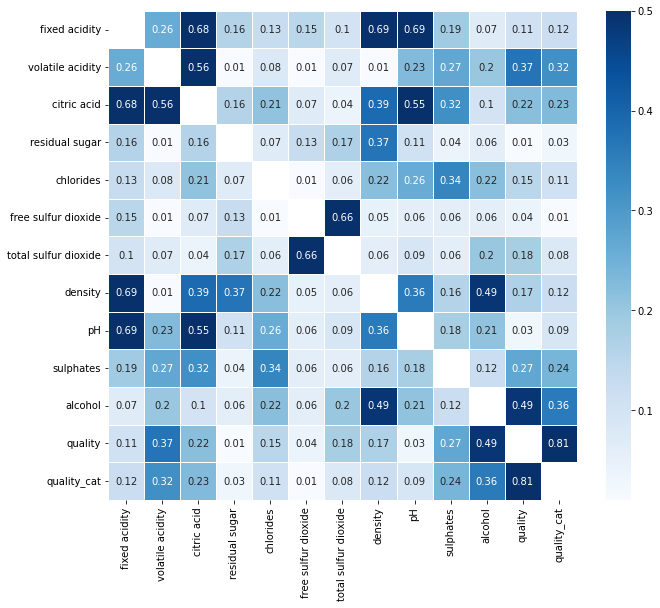

-----------
White Wine
-----------


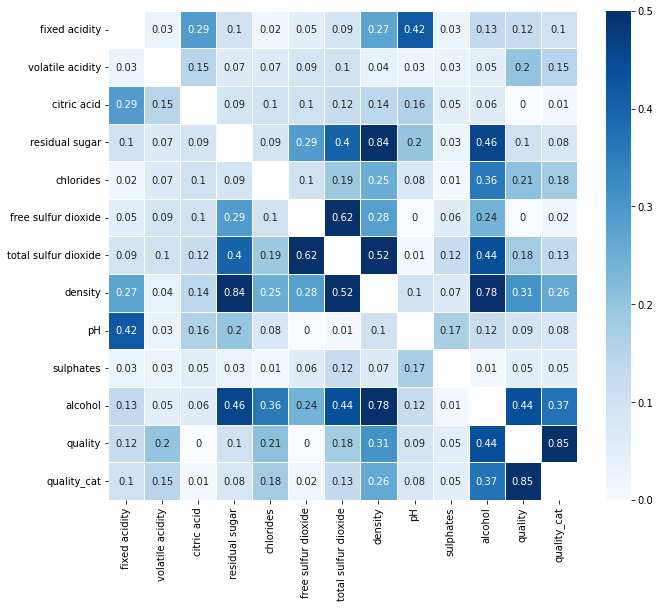

In [17]:
# Set figure size within context so it doesn't affect size of subsequent figures
with plt.rc_context({'figure.figsize':(10.5,9)}):
    # For each or red win and white wine dataframes
    for w in rw, ww:
        # Print the dataframe name
        print(f"-----------\n{w.name}\n-----------")
        # Calculate correlation matrix (using Pearson's r)
        corr = w.corr()
        # Remove distracting self correlations (always = 1)
        np.fill_diagonal(corr.values, 'NaN')
        # Display matrix as heatmap, saturate at 0.5 to make high correlations stand out
        sns.heatmap(abs(corr.round(2)), annot=True, linewidths=0.5, cmap='Blues', vmax=0.5)
        plt.show()

***

### Assess relative influence of each feature on the target variable

The tables below are the the `quality` columns from the correlation matrix calculated earlier, ordered (descending) by correlation coefficient. 

The features which influence red wine `quality` are dominated by `alcohol` and `volatile acidity`, with `sulphates`, `citric acid`, `total sulfur dioxide`, `density`, `chlorides`, and `fixed acidity` having moderate to low influences. `pH`, `free sulfur dioxide`, and `residual sugar` all have a very low correlation with wine quality. White wine `quality` is most influenced by `alcohol` and `density`. `Chlorides`, `volatile acidity`, `total sulfur dioxide`, and `fixed acidity` all exhibit a moderate influence, while `pH`, `residual sugar`, and `sulphates` show low correlation. The influences of `citric acid` and `free sulfur dioxide` are extremely low.

In [18]:
# Sort values in the correlation matrix by the absolute correlation with the target variable
for w in rw, ww:
    print(f"-----------\n{w.name}\n-----------")
    # print the sorted absolute values of the correlation between each feature and quality
    print(abs(w.corr()['quality']).drop('quality').sort_values(ascending=False))

-----------
Red Wine
-----------
quality_cat             0.812540
alcohol                 0.488963
volatile acidity        0.374621
sulphates               0.268653
citric acid             0.219440
total sulfur dioxide    0.184991
density                 0.174624
chlorides               0.151467
fixed acidity           0.111201
free sulfur dioxide     0.043654
pH                      0.031376
residual sugar          0.008920
Name: quality, dtype: float64
-----------
White Wine
-----------
quality_cat             0.850943
alcohol                 0.437074
density                 0.310081
chlorides               0.210836
volatile acidity        0.204161
total sulfur dioxide    0.177894
fixed acidity           0.118621
residual sugar          0.101612
pH                      0.092867
sulphates               0.047130
free sulfur dioxide     0.003938
citric acid             0.000863
Name: quality, dtype: float64


***

## Feature scaling
[8]
Standardisation is the process of scaling data so that it has a mean of zero and unit variance. Assumed by PCA and rbf kernel and LDA [11] [12]

In [19]:
scaler_rw = StandardScaler()
X_std_rw = scaler_rw.fit_transform(X_train_rw)
scaler_ww = StandardScaler()
X_std_ww = scaler_ww.fit_transform(X_train_ww)

***

## Dimensionality reduction

### Feature selection

1. Drop any features with an absolute correlation of less than 0.1
1. Drop features that are highly correlated

In [20]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropLessImportantFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.1):
        self.threshold=threshold
    def fit(self, X, y):
        # Calculate correlation coefficients, only keep the last one
        # because we only want each feature's correlation with y
        self.to_drop = abs(np.corrcoef(X, y, rowvar=False)[:,-1]) < self.threshold
        return self
    def transform(self, X):
        # Remove columns (features) where correlation coefficient with
        # y (output variable) is lower than threshold
        return np.delete(X, self.to_drop[0:-1], axis=1)

In [21]:
# Use transformer defined above to drop features with a correlation of 
# less than 0.1 with the output variable (quality) from the standardised 
# red and white wine datasets
drop_rw = DropLessImportantFeatures()
X_std_rw_dropped = drop_rw.fit_transform(X_std_rw, y_train_rw)
drop_ww = DropLessImportantFeatures()
X_std_ww_dropped = drop_ww.fit_transform(X_std_ww, y_train_ww)

In [22]:
X_std_rw_dropped.dtype

dtype('float64')

Examining the shape attribute of the red and white wine feature arrays shows that of the original 11 features in each dataset, red wine now has 8 and white wine has 7.

In [23]:
X_std_rw_dropped.shape

(1279, 8)

In [24]:
X_std_ww_dropped.shape

(3918, 7)

We can also try removing one of every pair of strongly correlated features. This is a very naive mode of dimensionality reduction - as can be seen below, 99% of variance can be preserved in just 3 principal components.

In [25]:
# Custom Transformer for dropping features based on correlation with output variable
# Putting this functionality in a transformer allows it to be used in a pipeline and 
# grid/randomised search hyperparameter tuning
class DropCorrelatedFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.5):
        self.threshold=threshold
    def fit(self, X):
        # Make temp copy of X
        c = X.copy()
        
        # Calculate absolute correlation matrix for all input features
        # Loop control variable
        max_sums = -1
        # List to hold indexes of features to drop
        idxs = []
        # Loop until there are no correlations above the threshold
        while max_sums != 0:
            # Calculate absolute correlation matrix
            corr = abs(np.corrcoef(c, rowvar=False))
            # Fill diagonal with zeroes
            np.fill_diagonal(corr, 0)
            # construct boolean matrix based on threshold 
            corr = corr >= self.threshold
            # calculate number of features that correlate with each feature
            sums = np.sum(corr, axis=1)
            # get index of max value
            idx = np.argmax(sums)
            # Index in original array will not always match index in current 
            # array as one column is deleted on each iteration
            # If the new index is less than the last index then it can be used unchanged
            if len(idxs) > 0 | idx < idxs[-1]:
                idxs.append(idx)
            # otherwise the number of removed columns must be added
            else:
                idxs.append(idx+len(idxs))
            # Delete the column at the current index from the temporary array
            c = np.delete(c, idx, axis=1)
            # update the loop variable
            max_sums = max(sums)
            
        self.idxs = idxs
        return self
    def transform(self, X):
        # Remove columns (features) which correlate over the threshold with other features
        return np.delete(X, self.idxs, axis=1)


In [26]:
dd = DropCorrelatedFeatures(threshold=0.497)
X_std_rw_d = dd.fit_transform(X_std_rw)

### Principal components analysis (PCA)

In [27]:
# [7] PCA
# Calculate prinicpal components of each dataset, preserving 99 % of variance
pca_rw = PCA(n_components=0.99)
pca_ww = PCA(n_components=0.99)
X_pca_rw = pca_rw.fit_transform(X_std_rw)
X_pca_ww = pca_ww.fit_transform(X_std_ww)

### Kernel PCA

In [28]:
# [8] Kernel PCA
# Calculate the first three principal components of each dataset using 
# KernelPCA with rbf kernel
kpca_rw = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_kpca_rw = kpca_rw.fit_transform(X_std_rw)
kpca_ww = KernelPCA(n_components=3, kernel="rbf", gamma=0.04)
X_kpca_ww = kpca_ww.fit_transform(X_std_ww)

In [39]:
pipeline = Pipeline([
    #('standard', StandardScaler()),
    #('minmax', MinMaxScaler()),
    #('dropunimp', DropLessImportantFeatures(threshold=0.497)),
    #('dropcorr', DropCorrelatedFeatures()),
    #('pca', PCA()),
    #('kpca', KernelPCA(kernel="rbf")),
    ('rnd_clf', RandomForestClassifier(n_jobs=-1)),
    #('svm_clf', SVC(kernel="poly", degree=3, coef0=1, C=5))
])

param_grid = { #'kpca__n_components': [0.95, 0.99],
               #'kpca__kernel': ["poly", "rbf", "sigmoid"],
#                'svm_clf__kernel': ["poly", "rbf", "sigmoid"],
#                'svm_clf__C': [1, 5, 10],
#                'svm_clf__coef0': [0, 0.1, 1],
#                'svm_clf__degree': [2, 3, 4],
                 'rnd_clf__n_estimators': [5000],
                 'rnd_clf__max_leaf_nodes': [128],
             }
# param_grid = [{'minmax': ['passthrough'],
#                'dropunimp': ['passthrough', DropLessImportantFeatures(0.01), DropLessImportantFeatures(0.1), DropLessImportantFeatures(0.2)],
#                'dropcorr': ['passthrough', DropCorrelatedFeatures(0.4), DropCorrelatedFeatures(0.5), DropCorrelatedFeatures(0.7)],
#                'pca': ['passthrough'],
#                'kpca': ['passthrough'] }]  


grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train_rw, y_train_cat_rw)

GridSearchCV(cv=5, error_score='raise',
             estimator=Pipeline(steps=[('rnd_clf',
                                        RandomForestClassifier(n_jobs=-1))]),
             param_grid={'rnd_clf__max_leaf_nodes': [128],
                         'rnd_clf__n_estimators': [5000]})

In [31]:
grid_search.best_estimator_

Pipeline(steps=[('rnd_clf',
                 RandomForestClassifier(max_leaf_nodes=64, n_estimators=1000,
                                        n_jobs=-1))])

In [32]:
grid_search.best_score_

0.8710049019607844

In [33]:
y_pred = grid_search.predict(X_test_rw)
#cm = confusion_matrix(y_test_cat_rw, y_pred, labels=['low', 'medium', 'high'])

In [36]:
cm = confusion_matrix(y_test_cat_rw, y_pred, labels=[0,1,2])
cm

array([[  1,  12,   0],
       [  0, 253,  11],
       [  0,  27,  16]])

<Figure size 216x144 with 0 Axes>

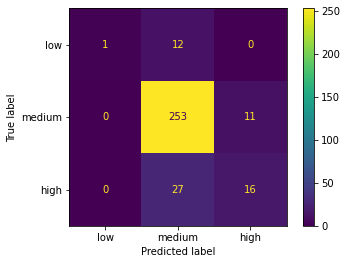

In [37]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_test_cat_rw, y_pred, display_labels=['low', 'medium', 'high'])
plt.grid(False)
plt.show()

In [38]:
precision = precision_score(y_test_cat_rw, y_pred, average='weighted')
recall = recall_score(y_test_cat_rw, y_pred, average='weighted')
f1 = f1_score(y_test_cat_rw, y_pred, average='weighted')
print(f"Precision: {precision}\nRecall: {recall}\nf1: {f1}\n")

Precision: 0.8350662734652461
Recall: 0.84375
f1: 0.8180414953751285



In [ ]:
model = SVC(kernel="poly", degree=3, coef0=1, C=5)
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])

model.fit(X_kpca_rw,y_train_cat_rw)

In [ ]:
X1 = scaler_rw.transform(X_test_rw)
X1 = drop_rw.transform(X1)
#X1 = kpca_rw.transform(X1)
model.score(X1, y_test_cat_rw)

In [ ]:
le = LabelEncoder()
xx = le.fit_transform(y_train_rw)

In [ ]:
y_train_rw.unique()

In [ ]:
np.unique(xx)

### Cross validation

In [ ]:
scores = cross_val_score(model, X1, y_test_cat_rw, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

In [ ]:
y_pred = cross_val_predict(model, X1, y_test_cat_rw, cv=10)
cm = confusion_matrix(y_test_cat_rw, y_pred, labels=['low', 'medium', 'high'])

In [ ]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_test_cat_rw, y_pred)
plt.grid(False)
plt.show()

In [ ]:
precision_score(y_test_cat_rw, y_pred, average='weighted')

In [ ]:
recall_score(y_test_cat_rw, y_pred, average='weighted')

In [ ]:
f1_score(y_test_cat_rw, y_pred, average='weighted')

### Stratified shuffle split

In [ ]:
rwdd =rwd.drop(['quality'], axis=1)

In [ ]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=10)
X, y = rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']
for train_idx, test_idx in sss.split(rwdd.drop(['quality_cat'], axis=1), rwdd['quality_cat']):
    X_train, X_test = X.loc[train_idx], X.loc[test_idx] 
    y_train, y_test = y.loc[train_idx], y.loc[test_idx]


In [ ]:
# svm_clf = Pipeline([
#     ("scaler", StandardScaler()),
#     ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
# ])
svm_clf = make_pipeline(StandardScaler(), SVC(kernel="poly", degree=3, coef0=1, C=5))
svm_clf.fit(X_train, y_train)

In [ ]:
svm_clf.score(X_test, y_test)

In [ ]:
scores = cross_val_score(svm_clf, X, y, cv=10)
print(scores, '\n', scores.mean(), '\n', scores.std())

In [ ]:
y_train_pred = cross_val_predict(svm_clf, X_train, y_train, cv=5)

In [ ]:
cm = confusion_matrix(y_train, y_train_pred, labels=['low', 'medium', 'high'])

In [ ]:
plt.figure(figsize=(3,2))
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, labels=['low', 'medium', 'high'])
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score
avg = 'weighted'
for score in (precision_score, recall_score, f1_score):
    print(f"{score.__name__}: {score(y_train, y_train_pred, average=avg)}")
          
          
precision = precision_score(y_train, y_train_pred, average=avg)
recall = recall_score(y_train, y_train_pred, average=avg)
f1 = f1_score(y_train, y_train_pred, average=avg)
print(precision, recall, f1)

### All medium classifier

In [ ]:
class alwaysMedium(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return(['medium'] * len(X))

In [ ]:
model = alwaysMedium()
scores = cross_val_score(model, X, y, cv=10, scoring="accuracy")
print(scores, '\n', scores.mean(), '\n', scores.std())

***
***

## References

[1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html

[4] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol

[5] https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split

[6] Should we apply normalization to test data as well? https://datascience.stackexchange.com/a/27616

[7] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:223

[8] https://stats.stackexchange.com/a/69159 Why do we need to normalize data before principal component analysis (PCA)?

[9] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:227

[10] Géron, A., 2019, Hands-on Machine Learning with Scikit-Learn, Keras & TensorFlow, O' Reilly: Sebastopol p:233  #### LDA good to reduce dimensionality before another classifcation algorithm such as SVM

[11] https://scikit-learn.org/stable/modules/preprocessing.html Standardization, or mean removal and variance scaling

[12] https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html sklearn.discriminant_analysis.LinearDiscriminantAnalysis "The model fits a Gaussian density to each class, assuming that all classes share the same covariance matrix."